In [1]:
from jsonschema.exceptions import best_match
from torchvision.datasets import MNIST, CIFAR10
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets, cifar10_augment, basic_cifar10_augment
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.layer.blocks import BasicBlock
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [2]:
cp.random.seed(42)


# 1. 数据加载与预处理
train_dataset = CIFAR10(
    root="../cifar10",
    train=True,
    transform=basic_cifar10_augment(train=True),
    download=False
)
test_dataset = CIFAR10(
    root="../cifar10",
    train=False,
    transform=basic_cifar10_augment(train=False),
    download=False
)

In [3]:
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)

train_set = (train_images[:45000], train_labels[:45000])
dev_set   = (train_images[45000:], train_labels[45000:])
test_set  = (test_images,       test_labels)

In [4]:
import numpy as np

print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [8]:
weight_decay_val = 0.001

layers2 = [
    Conv(in_channel=3, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=64, out_channel=128, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 128, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=128, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Conv(in_channel=256, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=256, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),

    Flatten(),
    Linear(in_channel=512 * 1 * 1, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]


In [9]:
model2 = Model(layers2)
optimizer2 = Adam(model=model2, lr=0.001)
loss_fn2  = CrossEntropy(model=model2)
runner2  = RunnerM(model=model2, loss=loss_fn2, optimizer=optimizer2)

[Adversarial Train] Epoch 1/20: 100%|██████████| 352/352 [20:51<00:00,  3.56s/batch, accuracy=0.514, loss=1.39]
train_loss: 1.18591, train_acc: 0.56863
dev_loss  : 1.20218, dev_acc  : 0.56275
### Best model saved to: best_models_PGD\2025-05-30_18-02-35\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.56275
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/20: 100%|██████████| 352/352 [26:16<00:00,  4.48s/batch, accuracy=0.556, loss=1.21] 
train_loss: 0.89505, train_acc: 0.69170
dev_loss  : 0.95380, dev_acc  : 0.66801
### Best model saved to: best_models_PGD\2025-05-30_18-02-35\best_model.pickle
### Best validation accuracy updated: 0.56275 -> 0.66801
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/20: 100%|██████████| 352/352 [19:45<00:00,  3.37s/batch, accuracy=0.681, loss=0.95] 
train_loss: 0.69841, train_acc: 0.76638
dev_loss  : 0.80650, dev_acc  : 0.71759
### Best model saved to: best_models_PGD\2025-05-30_18-02-35\best_model.pickle
### Best vali

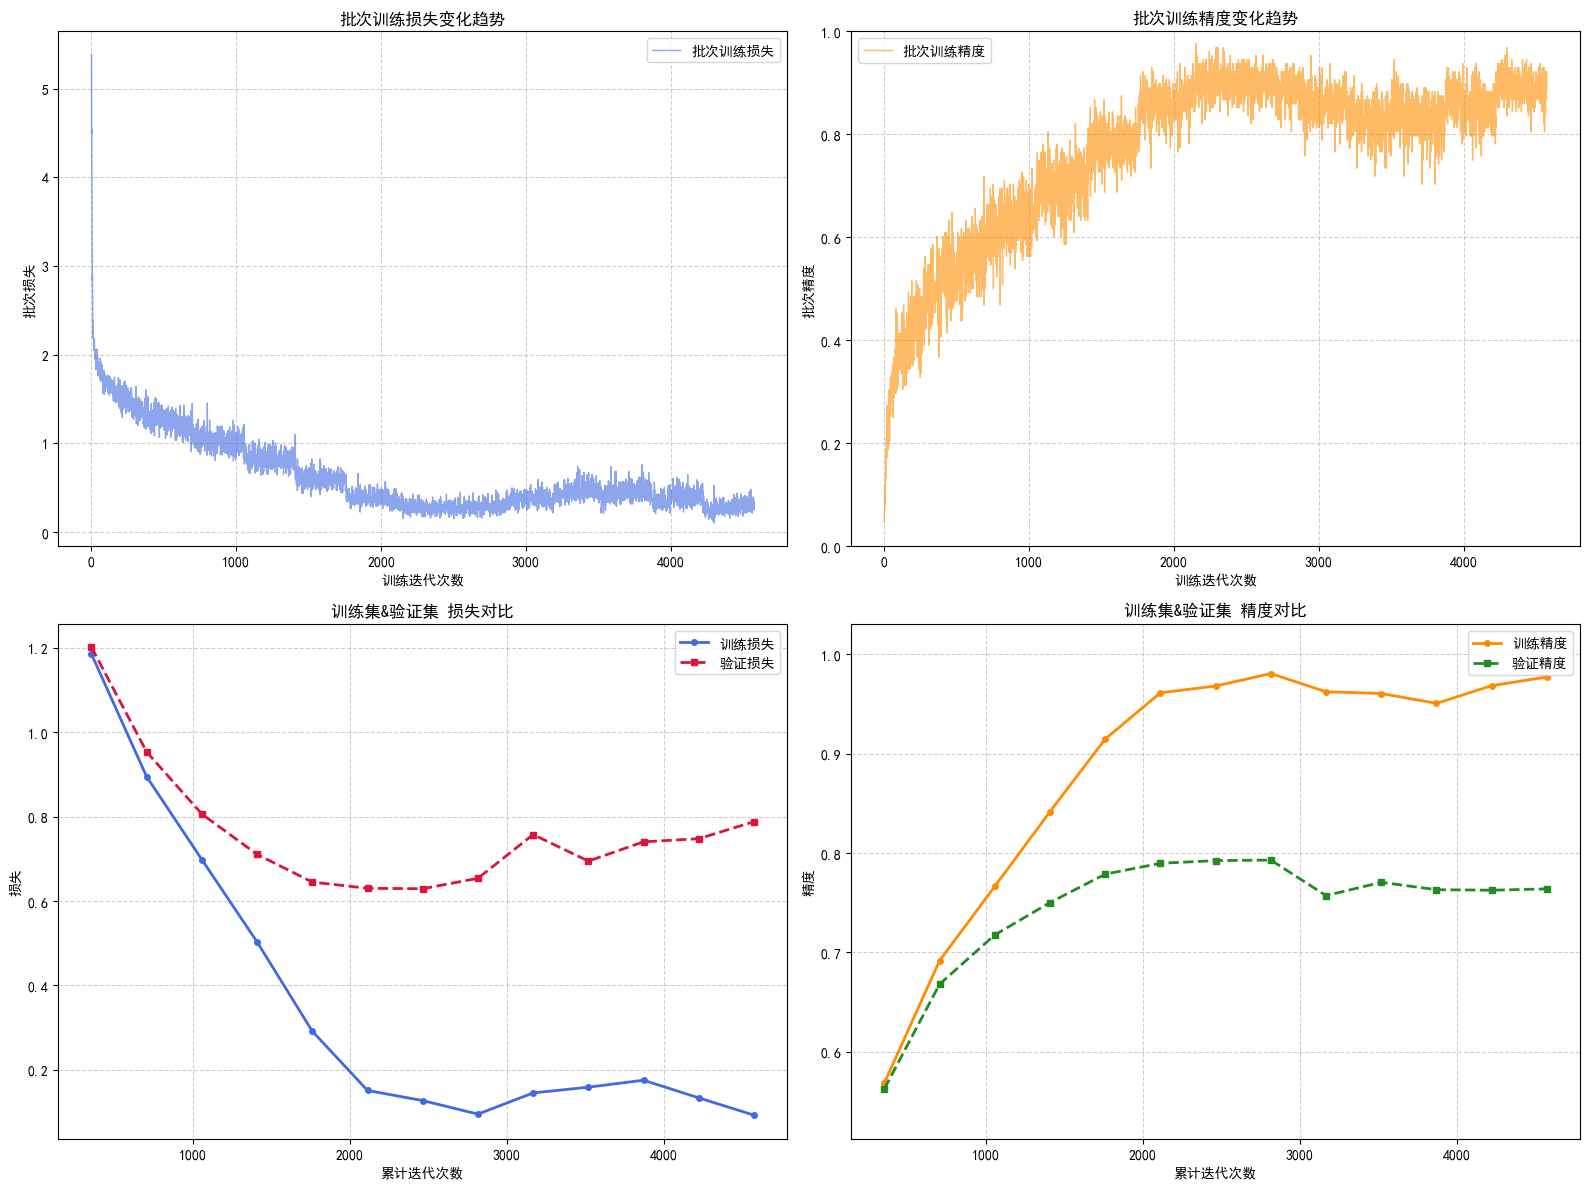

In [10]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=128,
        num_epochs=20,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer2,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        epsilon=2/255,
        shuffle=True,
        attack_strategy='PGD',
        save_dir='best_models_PGD',
        num_steps=5,
        step_size=0.5/255,
    )

In [12]:
advmodel= Model().load_model('best_models_PGD/cifar10_pgd_vgg/best_model.pickle')

Model loaded from: best_models_PGD\cifar10_pgd_vgg\best_model.pickle


In [14]:
advloss_fn = CrossEntropy(model=advmodel)
advrunner = RunnerM(model=advmodel, loss=advloss_fn, optimizer=None)

In [15]:
test_loss, test_acc = advrunner.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.73142, Test accuracy: 0.76990


In [16]:
from mynn.attack import *
adv_test_images = pgd_attack(
    model=advmodel,
    images=test_images,
    labels=test_labels,
    loss_fn=advloss_fn,
    epsilon=2 / 255,
    num_steps=5,
    step_size=0.5 / 255
)

test_set_adv = (adv_test_images, test_labels)

In [17]:
adv_loss, adv_acc = advrunner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.53833, Test accuracy: 0.57723
